
# **Building A Movie Recommandation System With Pytorch (layers Comparision)**
In this project, we are trying to predict the ratings that a user will give to an unseen movie, based on the ratings he gave to other movies. We will use the movielens dataset.The Main folder, which is ml-100k contains informations about 100 000 movies. We will use AutoEncoders to create our recommandation system. Let's start by importing the required libraries.





In [ ]:
# AutoEncoders

# Importing the libraries

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import time

import matplotlib.pyplot as plt


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving u1.base to u1.base


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving u1.test to u1.test


#Model architecture: nb_movies,20,20,10,10,20,20,nb_movies

* TRAINING LOSS: 0.9146
* TEST LOSS: 0.9498
* RMSE: 0.9745

In [ ]:
training = ['user_id', 'movie_id', 'rating', 'timestamp' ] #Create each column
test = ['user_id', 'movie_id', 'rating', 'timestamp' ]     #Create each column

In [ ]:
# Preparing the training set and the test set 
training_set = pd.read_csv('u1.base', names=training, delimiter = '\t') # Read the file
test_set = pd.read_csv('u1.test', names=test, delimiter = '\t') #Read the file

In [ ]:
#Drop 'timestamp' column
training_set= training_set.drop(["timestamp"], axis=1)

In [ ]:
#Drop 'timestamp' column
test_set= test_set.drop(["timestamp"], axis=1)

In [ ]:
# Visualizing the first elements of the training_set
training_set.head()

,user_id,movie_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [ ]:
# Converting the training and test sets into numpy arrays
training_set = np.array(training_set, dtype = 'int')
test_set = np.array(test_set, dtype = 'int')

In [ ]:
# Getting the number of users and movies
nb_users = int(max(max(training_set[:, 0]), max(test_set[:, 0])))
nb_movies = int(max(max(training_set[:, 1]), max(test_set[:, 1])))

In [ ]:
print("Number of users: {}".format(nb_users))
print("Number of movies: {}".format(nb_movies))

Number of users: 943
Number of movies: 1682


In [ ]:
def convert(data):
    # Initializing an empty list that will take the list of ratings given by a specific user
    new_data = []
    # Looping over all the users
    for id_users in range(1, nb_users + 1):
        # We get the id of the movies rated by the current user
        id_movies = data[:, 1][data[:, 0] == id_users]
        # We get the id of the ratings given by the current_user
        id_ratings = data[:, 2][data[:, 0] == id_users]
        # 
        ratings = np.zeros(nb_movies)
        # For movies rated by the current user, we replace 0 with the rating
        # The first element of ratings is at index 0. However, id_movies start at index 1.
        # Therefore, ratings[id_movies - 1] will correspond to the location of the movie we're considering
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data

In [ ]:
# Applying the convert function to the training and test set.
training_set = convert(training_set)
test_set = convert(test_set)

In [ ]:
# Convert the data into Torch tensors
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

In [ ]:
# Create the SAE (stack autoencoder) class, which is inherited from nn.Module(Pytorch library)
class SAE(nn.Module):
    # Initializing the class
    def __init__(self, ):
        # making the class get all the functions from the parent class nn.Module
        super(SAE, self).__init__()
        # Creating the first encoding layer. The number of input corresponds to the number of movies
        #  Decide to encode it into 20 outputs
        self.fc1 = nn.Linear(nb_movies, 20)
        # Creating the second encoding layer. From 20 inputs to 10 outputs
        self.fc2 = nn.Linear(20, 10)
        # Creating the first decoding layer. From 20 inputs to 10 outputs
        self.fc3 = nn.Linear(10, 20)
        # Creating the second hidden layer. From 20 inputs to nb_movies outputs
        self.fc4 = nn.Linear(20, nb_movies)

        #####  Activation Function: Sigmoid   #######

        # Creating the activation fucntion which will fire up specific neurons 
        self.activation = nn.Sigmoid()
        
        # Creating the function for forward propagation
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        # With autoencoder, we don't need an activation function for the last decoding part
        x = self.fc4(x)
        return x

    def predict(self, x): # x: visible nodes
        x = self.forward(x)
        return x

  


  

In [ ]:
 #Creating an instance of our SAE class
sae = SAE()


 #Defining a criterion which specifies the metric to minimize.
 #In this case, we want to minimize the MSE (Mean Squared Error)

criterion = nn.MSELoss()

# Defining the algorithm used to minimize the loss function. 
#In this case, we'll use RMSprop

optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)


In [ ]:


#time
time_start = time.time()
# Setting the number of epochs
nb_epoch = 200

# storing the  traning loss calculations
losses = [] 

# Iterating over each epoch
for epoch in range(1, nb_epoch + 1):
    # Initializing the train_loss which will be updated
    train_loss = 0
    # Initializing a counter
    s = 0.
    # Iterating over each user
    for id_user in range(nb_users):
        # The input corresponds to the ratings given by the current user for each movie
        input = Variable(training_set[id_user]).unsqueeze(0)
        target = input.clone()
        # We don't consider movies NOT rated by the current user. So we specify a conditional statement
        if torch.sum(target.data > 0) > 0:
            # We use our SAE to get the output from the 
            output = sae(input)
            target.require_grad = False
            output[target == 0] = 0
            # Defining our loss function, comparing the output with the target
            loss = criterion(output, target)
            mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
            # Computing the gradients necessary to adjust the weights
            loss.backward()
            # Updating the train_loss
            train_loss += np.sqrt(loss.data*mean_corrector)
            s += 1.
            # Updating the weights of the neural network
            optimizer.step()

    epoch_loss = train_loss / len(training_set[id_user])
    losses.append(epoch_loss)  
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))
time_end = time.time()
print('Stacked-Autoencoder(SAE) Training Time : ' +str(round((time_end-time_start)/60,0))+' Minutes. ')

epoch: 1 loss: tensor(1.7720)
epoch: 2 loss: tensor(1.0967)
epoch: 3 loss: tensor(1.0535)
epoch: 4 loss: tensor(1.0383)
epoch: 5 loss: tensor(1.0308)
epoch: 6 loss: tensor(1.0266)
epoch: 7 loss: tensor(1.0242)
epoch: 8 loss: tensor(1.0220)
epoch: 9 loss: tensor(1.0208)
epoch: 10 loss: tensor(1.0194)
epoch: 11 loss: tensor(1.0189)
epoch: 12 loss: tensor(1.0183)
epoch: 13 loss: tensor(1.0181)
epoch: 14 loss: tensor(1.0174)
epoch: 15 loss: tensor(1.0174)
epoch: 16 loss: tensor(1.0169)
epoch: 17 loss: tensor(1.0167)
epoch: 18 loss: tensor(1.0166)
epoch: 19 loss: tensor(1.0163)
epoch: 20 loss: tensor(1.0162)
epoch: 21 loss: tensor(1.0160)
epoch: 22 loss: tensor(1.0157)
epoch: 23 loss: tensor(1.0158)
epoch: 24 loss: tensor(1.0159)
epoch: 25 loss: tensor(1.0157)
epoch: 26 loss: tensor(1.0155)
epoch: 27 loss: tensor(1.0152)
epoch: 28 loss: tensor(1.0149)
epoch: 29 loss: tensor(1.0136)
epoch: 30 loss: tensor(1.0117)
epoch: 31 loss: tensor(1.0095)
epoch: 32 loss: tensor(1.0092)
epoch: 33 loss: t

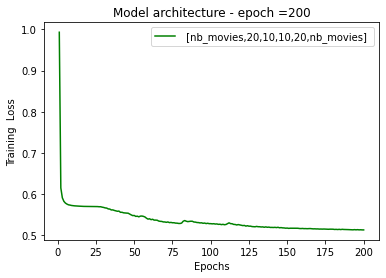

In [ ]:
epochs = range(1,201)
plt.plot(epochs, losses, 'g', label=' [nb_movies,20,10,10,20,nb_movies] ') # 'g' = color green
plt.title('Model architecture - epoch =200')
plt.xlabel('Epochs')
plt.ylabel('Training  Loss')

plt.legend()
plt.show()

In [ ]:
# Initializing the test_loss
sae.eval()
with torch.no_grad():
  test_loss = 0
  s = 0.
  for id_user in range(nb_users):
      input = Variable(training_set[id_user]).unsqueeze(0)
      target = Variable(test_set[id_user]).unsqueeze(0)
      if torch.sum(target.data > 0) > 0:
          output = sae(input)
          target.require_grad = False
          output[(target == 0)] = 0
          loss = criterion(output, target)
  
          mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
          test_loss += np.sqrt(loss.data*mean_corrector)
          s += 1.
  print('test_loss: '+str(test_loss/s))





test_loss: tensor(0.9498)


In [ ]:
from math import sqrt


In [ ]:
RMSE = sqrt(0.9498)

RMSE

0.9745768312452333

#Model architecture: nb_movies,25,25,12,12,25,25,nb_movies

* TRAINING LOSS: 0.8931
* TEST LOSS: 0.9407
* RMSE: 0.9698

In [ ]:
training = ['user_id', 'movie_id', 'rating', 'timestamp' ] #Create each column
test = ['user_id', 'movie_id', 'rating', 'timestamp' ]     #Create each column

In [ ]:
# Preparing the training set and the test set 
training_set = pd.read_csv('u1.base', names=training, delimiter = '\t') # Read the file
test_set = pd.read_csv('u1.test', names=test, delimiter = '\t') #Read the file

In [ ]:
#Drop 'timestamp' column
training_set= training_set.drop(["timestamp"], axis=1)

In [ ]:
#Drop 'timestamp' column
test_set= test_set.drop(["timestamp"], axis=1)

In [ ]:
# Visualizing the first elements of the training_set
training_set.head()

,user_id,movie_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [ ]:
# Converting the training and test sets into numpy arrays
training_set = np.array(training_set, dtype = 'int')
test_set = np.array(test_set, dtype = 'int')

In [ ]:
# Getting the number of users and movies
nb_users = int(max(max(training_set[:, 0]), max(test_set[:, 0])))
nb_movies = int(max(max(training_set[:, 1]), max(test_set[:, 1])))

In [ ]:
print("Number of users: {}".format(nb_users))
print("Number of movies: {}".format(nb_movies))

Number of users: 943
Number of movies: 1682


In [ ]:
def convert(data):
    # Initializing an empty list that will take the list of ratings given by a specific user
    new_data = []
    # Looping over all the users
    for id_users in range(1, nb_users + 1):
        # We get the id of the movies rated by the current user
        id_movies = data[:, 1][data[:, 0] == id_users]
        # We get the id of the ratings given by the current_user
        id_ratings = data[:, 2][data[:, 0] == id_users]
        # 
        ratings = np.zeros(nb_movies)
        # For movies rated by the current user, we replace 0 with the rating
        # The first element of ratings is at index 0. However, id_movies start at index 1.
        # Therefore, ratings[id_movies - 1] will correspond to the location of the movie we're considering
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data

In [ ]:
# Applying the convert function to the training and test set.
training_set = convert(training_set)
test_set = convert(test_set)

In [ ]:
# Convert the data into Torch tensors
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

In [ ]:
# Create the SAE (stack autoencoder) class, which is inherited from nn.Module(Pytorch library)
class SAE(nn.Module):
    # Initializing the class
    def __init__(self, ):
        # making the class get all the functions from the parent class nn.Module
        super(SAE, self).__init__()
        # Creating the first encoding layer. The number of input corresponds to the number of movies
        #  Decide to encode it into 25 outputs
        self.fc1 = nn.Linear(nb_movies, 25)
        # Creating the second encoding layer. From 25 inputs to 12 outputs
        self.fc2 = nn.Linear(25, 12)
        # Creating the first decoding layer. From 12 inputs to 25 outputs
        self.fc3 = nn.Linear(12, 25)
        # Creating the second hidden layer. From 25 inputs to nb_movies outputs
        self.fc4 = nn.Linear(25, nb_movies)

        #####  Activation Function: Sigmoid   #######

        # Creating the activation fucntion which will fire up specific neurons 
        self.activation = nn.Sigmoid()
        
        # Creating the function for forward propagation
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        # With autoencoder, we don't need an activation function for the last decoding part
        x = self.fc4(x)
        return x

    def predict(self, x): # x: visible nodes
        x = self.forward(x)
        return x

  


  

In [ ]:
 #Creating an instance of our SAE class
sae = SAE()


 #Defining a criterion which specifies the metric to minimize.
 #In this case, we want to minimize the MSE (Mean Squared Error)

criterion = nn.MSELoss()

# Defining the algorithm used to minimize the loss function. 
#In this case, we'll use RMSprop

optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)


In [ ]:

#time
time_start = time.time()
# Setting the number of epochs
nb_epoch = 200

# storing the  traning loss calculations
rlosses = [] 

# Iterating over each epoch
for epoch in range(1, nb_epoch + 1):
    # Initializing the train_loss which will be updated
    train_loss = 0
    # Initializing a counter
    s = 0.
    # Iterating over each user
    for id_user in range(nb_users):
        # The input corresponds to the ratings given by the current user for each movie
        input = Variable(training_set[id_user]).unsqueeze(0)
        target = input.clone()
        # We don't consider movies NOT rated by the current user. So we specify a conditional statement
        if torch.sum(target.data > 0) > 0:
            # We use our SAE to get the output from the 
            output = sae(input)
            target.require_grad = False
            output[target == 0] = 0
            # Defining our loss function, comparing the output with the target
            loss = criterion(output, target)
            mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
            # Computing the gradients necessary to adjust the weights
            loss.backward()
            # Updating the train_loss
            train_loss += np.sqrt(loss.data*mean_corrector)
            s += 1.
            # Updating the weights of the neural network
            optimizer.step()

    epoch_loss = train_loss / len(training_set[id_user])
    rlosses.append(epoch_loss)  
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))
time_end = time.time()
print('Stacked-Autoencoder(SAE) Training Time : ' +str(round((time_end-time_start)/60,0))+' Minutes. ')

epoch: 1 loss: tensor(1.6864)
epoch: 2 loss: tensor(1.0828)
epoch: 3 loss: tensor(1.0495)
epoch: 4 loss: tensor(1.0382)
epoch: 5 loss: tensor(1.0327)
epoch: 6 loss: tensor(1.0295)
epoch: 7 loss: tensor(1.0278)
epoch: 8 loss: tensor(1.0263)
epoch: 9 loss: tensor(1.0252)
epoch: 10 loss: tensor(1.0245)
epoch: 11 loss: tensor(1.0242)
epoch: 12 loss: tensor(1.0238)
epoch: 13 loss: tensor(1.0231)
epoch: 14 loss: tensor(1.0230)
epoch: 15 loss: tensor(1.0225)
epoch: 16 loss: tensor(1.0225)
epoch: 17 loss: tensor(1.0223)
epoch: 18 loss: tensor(1.0219)
epoch: 19 loss: tensor(1.0219)
epoch: 20 loss: tensor(1.0215)
epoch: 21 loss: tensor(1.0191)
epoch: 22 loss: tensor(1.0167)
epoch: 23 loss: tensor(1.0145)
epoch: 24 loss: tensor(1.0152)
epoch: 25 loss: tensor(1.0110)
epoch: 26 loss: tensor(1.0122)
epoch: 27 loss: tensor(1.0071)
epoch: 28 loss: tensor(1.0060)
epoch: 29 loss: tensor(1.0032)
epoch: 30 loss: tensor(1.0019)
epoch: 31 loss: tensor(0.9988)
epoch: 32 loss: tensor(0.9989)
epoch: 33 loss: t

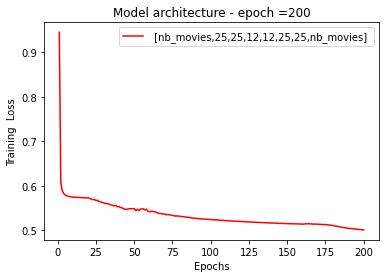

In [ ]:
epochs = range(1,201)
plt.plot(epochs, rlosses, 'r', label=' [nb_movies,25,25,12,12,25,25,nb_movies] ') # 'g' = color green
plt.title('Model architecture - epoch =200')
plt.xlabel('Epochs')
plt.ylabel('Training  Loss')

plt.legend()
plt.show()

In [ ]:
# Initializing the test_loss
sae.eval()
with torch.no_grad():
  test_loss = 0
  s = 0.
  for id_user in range(nb_users):
      input = Variable(training_set[id_user]).unsqueeze(0)
      target = Variable(test_set[id_user]).unsqueeze(0)
      if torch.sum(target.data > 0) > 0:
          output = sae(input)
          target.require_grad = False
          output[(target == 0)] = 0
          loss = criterion(output, target)
  
          mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
          test_loss += np.sqrt(loss.data*mean_corrector)
          s += 1.
          pred = sae(target)
  print('test_loss: '+str(test_loss/s))





test_loss: tensor(0.9407)


In [ ]:
from math import sqrt


In [ ]:
RMSE = sqrt(0.9407)

RMSE

0.9698969017374991

#Model architecture: nb_movies,20,20,nb_movies

* TRAINING LOSS: 0.7062
* TEST LOSS: 1.0230
* RMSE: 1.0220

In [ ]:
training = ['user_id', 'movie_id', 'rating', 'timestamp' ] #Create each column
test = ['user_id', 'movie_id', 'rating', 'timestamp' ]     #Create each column

In [ ]:
# Preparing the training set and the test set 
training_set = pd.read_csv('u1.base', names=training, delimiter = '\t') # Read the file
test_set = pd.read_csv('u1.test', names=test, delimiter = '\t') #Read the file

In [ ]:
#Drop 'timestamp' column
training_set= training_set.drop(["timestamp"], axis=1)

In [ ]:
#Drop 'timestamp' column
test_set= test_set.drop(["timestamp"], axis=1)

In [ ]:
# Visualizing the first elements of the training_set
training_set.head()

,user_id,movie_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


In [ ]:
# Converting the training and test sets into numpy arrays
training_set = np.array(training_set, dtype = 'int')
test_set = np.array(test_set, dtype = 'int')

In [ ]:
# Getting the number of users and movies
nb_users = int(max(max(training_set[:, 0]), max(test_set[:, 0])))
nb_movies = int(max(max(training_set[:, 1]), max(test_set[:, 1])))

In [ ]:
print("Number of users: {}".format(nb_users))
print("Number of movies: {}".format(nb_movies))

Number of users: 943
Number of movies: 1682


In [ ]:
def convert(data):
    # Initializing an empty list that will take the list of ratings given by a specific user
    new_data = []
    # Looping over all the users
    for id_users in range(1, nb_users + 1):
        # We get the id of the movies rated by the current user
        id_movies = data[:, 1][data[:, 0] == id_users]
        # We get the id of the ratings given by the current_user
        id_ratings = data[:, 2][data[:, 0] == id_users]
        # 
        ratings = np.zeros(nb_movies)
        # For movies rated by the current user, we replace 0 with the rating
        # The first element of ratings is at index 0. However, id_movies start at index 1.
        # Therefore, ratings[id_movies - 1] will correspond to the location of the movie we're considering
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data

In [ ]:
# Applying the convert function to the training and test set.
training_set = convert(training_set)
test_set = convert(test_set)

In [ ]:
# Convert the data into Torch tensors
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

In [ ]:
# Create the SAE (stack autoencoder) class, which is inherited from nn.Module(Pytorch library)
class SAE(nn.Module):
    # Initializing the class
    def __init__(self, ):
        # making the class get all the functions from the parent class nn.Module
        super(SAE, self).__init__()
        # Creating the first encoding layer. The number of input corresponds to the number of movies
        #  Decide to encode it into 20 outputs
        self.fc1 = nn.Linear(nb_movies, 20)    
        # Creating the second hidden layer. From 20 inputs to nb_movies outputs
        self.fc4 = nn.Linear(20, nb_movies)

        #####  Activation Function: Sigmoid   #######

        # Creating the activation fucntion which will fire up specific neurons 
        self.activation = nn.Sigmoid()
        
        # Creating the function for forward propagation
    def forward(self, x):
        x = self.activation(self.fc1(x))
        # With autoencoder, we don't need an activation function for the last decoding part
        x = self.fc4(x)
        return x

    def predict(self, x): # x: visible nodes
        x = self.forward(x)
        return x

  


  

In [ ]:
 #Creating an instance of our SAE class
sae = SAE()


 #Defining a criterion which specifies the metric to minimize.
 #In this case, we want to minimize the MSE (Mean Squared Error)

criterion = nn.MSELoss()

# Defining the algorithm used to minimize the loss function. 
#In this case, we'll use RMSprop

optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)


In [ ]:

#time
time_start = time.time()
# Setting the number of epochs
nb_epoch = 200

# storing the  traning loss calculations
alosses = [] 

# Iterating over each epoch
for epoch in range(1, nb_epoch + 1):
    # Initializing the train_loss which will be updated
    train_loss = 0
    # Initializing a counter
    s = 0.
    # Iterating over each user
    for id_user in range(nb_users):
        # The input corresponds to the ratings given by the current user for each movie
        input = Variable(training_set[id_user]).unsqueeze(0)
        target = input.clone()
        # We don't consider movies NOT rated by the current user. So we specify a conditional statement
        if torch.sum(target.data > 0) > 0:
            # We use our SAE to get the output from the 
            output = sae(input)
            target.require_grad = False
            output[target == 0] = 0
            # Defining our loss function, comparing the output with the target
            loss = criterion(output, target)
            mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
            # Computing the gradients necessary to adjust the weights
            loss.backward()
            # Updating the train_loss
            train_loss += np.sqrt(loss.data*mean_corrector)
            s += 1.
            # Updating the weights of the neural network
            optimizer.step()

    epoch_loss = train_loss / len(training_set[id_user])
    alosses.append(epoch_loss)  
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))
time_end = time.time()
print('Stacked-Autoencoder(SAE) Training Time : ' +str(round((time_end-time_start)/60,0))+' Minutes. ')

epoch: 1 loss: tensor(1.6976)
epoch: 2 loss: tensor(1.0970)
epoch: 3 loss: tensor(1.0543)
epoch: 4 loss: tensor(1.0385)
epoch: 5 loss: tensor(1.0305)
epoch: 6 loss: tensor(1.0258)
epoch: 7 loss: tensor(1.0227)
epoch: 8 loss: tensor(1.0201)
epoch: 9 loss: tensor(1.0183)
epoch: 10 loss: tensor(1.0168)
epoch: 11 loss: tensor(1.0157)
epoch: 12 loss: tensor(1.0147)
epoch: 13 loss: tensor(1.0140)
epoch: 14 loss: tensor(1.0133)
epoch: 15 loss: tensor(1.0129)
epoch: 16 loss: tensor(1.0122)
epoch: 17 loss: tensor(1.0115)
epoch: 18 loss: tensor(1.0113)
epoch: 19 loss: tensor(1.0107)
epoch: 20 loss: tensor(1.0104)
epoch: 21 loss: tensor(1.0096)
epoch: 22 loss: tensor(1.0092)
epoch: 23 loss: tensor(1.0089)
epoch: 24 loss: tensor(1.0080)
epoch: 25 loss: tensor(1.0076)
epoch: 26 loss: tensor(1.0069)
epoch: 27 loss: tensor(1.0052)
epoch: 28 loss: tensor(1.0029)
epoch: 29 loss: tensor(1.0012)
epoch: 30 loss: tensor(0.9991)
epoch: 31 loss: tensor(0.9970)
epoch: 32 loss: tensor(0.9953)
epoch: 33 loss: t

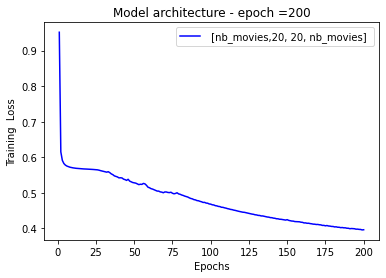

In [ ]:
epochs = range(1,201)
plt.plot(epochs, alosses, 'b', label=' [nb_movies,20, 20, nb_movies] ') # 'g' = color green
plt.title('Model architecture - epoch =200')
plt.xlabel('Epochs')
plt.ylabel('Training  Loss')

plt.legend()
plt.show()

In [ ]:
# Initializing the test_loss
sae.eval()
with torch.no_grad():
  test_loss = 0
  s = 0.
  for id_user in range(nb_users):
      input = Variable(training_set[id_user]).unsqueeze(0)
      target = Variable(test_set[id_user]).unsqueeze(0)
      if torch.sum(target.data > 0) > 0:
          output = sae(input)
          target.require_grad = False
          output[(target == 0)] = 0
          loss = criterion(output, target)
  
          mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
          test_loss += np.sqrt(loss.data*mean_corrector)
          s += 1.
          pred = sae(target)
  print('test_loss: '+str(test_loss/s))





test_loss: tensor(1.0220)


In [ ]:
from math import sqrt


In [ ]:
RMSE = sqrt(1.0220)

RMSE

1.010940156488009

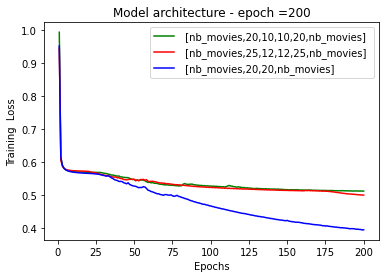

In [ ]:
epochs = range(1,201)
plt.plot(epochs, losses, 'g', label=' [nb_movies,20,10,10,20,nb_movies] ') 
plt.plot(epochs, rlosses, 'r', label=' [nb_movies,25,12,12,25,nb_movies] ') 
plt.plot(epochs, alosses, 'b', label=' [nb_movies,20,20,nb_movies] ') 

plt.title('Model architecture - epoch =200')
plt.xlabel('Epochs')
plt.ylabel('Training  Loss')

plt.legend()
plt.show()